In [46]:
using Interact
using LCMGL
using StaticArrays
using CoordinateTransformations
using RigidBodyDynamics
using DataFrames, DataArrays
using Ipopt
using ColorTypes: RGB
using DrakeVisualizer
using Plots
using StatPlots
gr()
import RigidBodyTreeInspector

In [11]:
DrakeVisualizer.any_open_windows() || DrakeVisualizer.new_window()

Process(`/Users/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/v0.5/DrakeVisualizer/src/../deps/usr/bin/drake-visualizer`, ProcessRunning)

In [54]:
import Flash
reload("Flash")

In [55]:
vis = DrakeVisualizer.Visualizer()
delete!(vis)

# Construct the manipulator
arm = Flash.Models.two_link_arm(false);

# Construct the sensor and draw its view rays for debugging
sensor = Flash.DepthSensors.Kinect(41, 41);
camera_origin = SVector(0., 0, 4)
camera_tform = compose(Translation(camera_origin), LinearMap(AngleAxis(pi, 1, 0, 0)))
Flash.DepthSensors.draw_rays(vis[:sensor], sensor, camera_tform)

state = Flash.ManipulatorState(arm)
setgeometry!(vis[:robot], arm)
settransform!(vis[:robot], state)
Flash.draw_skin!(vis[:robot], state)

In [56]:
state = Flash.ManipulatorState(arm)
points = Flash.DepthSensors.raycast(state, sensor, camera_tform)
setgeometry!(vis[:sensed_points], PointCloud(points))

Visualizer with path prefix Symbol[:sensed_points] using LCM LCMCore.LCM(Ptr{Void} @0x00007fe52197f1a0,"",RawFD(102),LCMCore.Subscription[LCMCore.Subscription{LCMCore.SubscriptionOptions{DrakeVisualizer.Comms.CommsT,DrakeVisualizer.#handle_msg#7{DrakeVisualizer.CoreVisualizer}}}(LCMCore.SubscriptionOptions{DrakeVisualizer.Comms.CommsT,DrakeVisualizer.#handle_msg#7{DrakeVisualizer.CoreVisualizer}}(DrakeVisualizer.Comms.CommsT,DrakeVisualizer.handle_msg),Ptr{Void} @0x00007fe5219d8d50)])

In [57]:
@manipulate for x1 = linspace(-pi, pi, 101), x2 = linspace(-pi, pi, 101)
    set_configuration!(state,  [x1, x2])
    settransform!(vis[:robot], state)
    points = Flash.DepthSensors.raycast(state, sensor, camera_tform)
    setgeometry!(vis[:sensed_points], GeometryData(PointCloud(points), RGB(0, 1, 0)))
    Flash.draw_skin!(vis[:robot], state)
end

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(0.0, nactions=1),"x1",0.0,"0.0",Interact.OptionDict(DataStructures.OrderedDict("-3.141592653589793"=>-3.14159,"-3.0787608005179976"=>-3.07876,"-3.015928947446201"=>-3.01593,"-2.9530970943744053"=>-2.9531,"-2.8902652413026093"=>-2.89027,"-2.827433388230814"=>-2.82743,"-2.7646015351590183"=>-2.7646,"-2.701769682087222"=>-2.70177,"-2.6389378290154264"=>-2.63894,"-2.57610597594363"=>-2.57611…),Dict(-0.816814=>"-0.8168140899333463",-3.01593=>"-3.015928947446201",-2.13628=>"-2.1362830044410597",1.19381=>"1.1938052083641215",1.88496=>"1.8849555921538756",2.13628=>"2.1362830044410597",1.75929=>"1.7592918860102842",-2.70177=>"-2.701769682087222",2.63894=>"2.6389378290154264",-2.45044=>"-2.450442269800039"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(0.0, nactions=1),"x2",0.0,"0.0",Interact.OptionDict(DataStructures.OrderedDict("-3.141592653589793"=>-3.14159,"-3.0787608005179976"=>-3.07876,"-3.015928947446201"=>-3.01593,"-2.9530970943744053"=>-2.9531,"-2.8902652413026093"=>-2.89027,"-2.827433388230814"=>-2.82743,"-2.7646015351590183"=>-2.7646,"-2.701769682087222"=>-2.70177,"-2.6389378290154264"=>-2.63894,"-2.57610597594363"=>-2.57611…),Dict(-0.816814=>"-0.8168140899333463",-3.01593=>"-3.015928947446201",-2.13628=>"-2.1362830044410597",1.19381=>"1.1938052083641215",1.88496=>"1.8849555921538756",2.13628=>"2.1362830044410597",1.75929=>"1.7592918860102842",-2.70177=>"-2.701769682087222",2.63894=>"2.6389378290154264",-2.45044=>"-2.450442269800039"…)),Any[],Any[],true,"horizontal")

nothing

In [58]:
# Difference between two angles, compensating for wraparound
# (taken from angleDiff.m in Drake)
function angle_diff(phi1, phi2)
    mod(phi2 - phi1 + pi, 2*pi) - pi;
end

angle_diff (generic function with 1 method)

In [59]:
# Now let's try to use the raycast data to recover the joint angles.
# We'll do that by choosing a true (hidden) robot state:
true_state = Flash.ManipulatorState(arm)
Flash.set_configuration!(true_state, [pi, 1.3])
settransform!(vis[:robot], true_state)
Flash.draw_skin!(vis[:robot], true_state)
# Now we can raycast that true state to get a set of sensed points:
sensed_points = Flash.DepthSensors.raycast(true_state, sensor, camera_tform)
setgeometry!(vis[:sensed_points], GeometryData(PointCloud(sensed_points), RGB(0, 1, 0)))

Visualizer with path prefix Symbol[:sensed_points] using LCM LCMCore.LCM(Ptr{Void} @0x00007fe52197f1a0,"",RawFD(102),LCMCore.Subscription[LCMCore.Subscription{LCMCore.SubscriptionOptions{DrakeVisualizer.Comms.CommsT,DrakeVisualizer.#handle_msg#7{DrakeVisualizer.CoreVisualizer}}}(LCMCore.SubscriptionOptions{DrakeVisualizer.Comms.CommsT,DrakeVisualizer.#handle_msg#7{DrakeVisualizer.CoreVisualizer}}(DrakeVisualizer.Comms.CommsT,DrakeVisualizer.handle_msg),Ptr{Void} @0x00007fe5219d8d50)])

In [60]:
function test_gradient_descent(model, sensed_points, true_state, loops)
    x_true = copy(Flash.flatten(true_state))
    trials = Vector{DataFrame}()
    
    for i = 1:loops
        errors = Float64[]
        xs = Vector{Float64}[]
        costs = Float64[]
        
        function callback{T}(x::AbstractVector{T}, c)
            # When computing errors, we'll just ignore the last three joints, since
            # they are almost impossible to track at this scale
            x_value = Flash.value.(x)
            push!(errors, norm(angle_diff.(x_value, x_true)))
            push!(xs, x_value)
            push!(costs, Flash.value(c))
            state = Flash.ManipulatorState(model)
            Flash.GradientDescent.unflatten!(state, x_value)
            settransform!(vis[:robot], state)
        end
        
        x_estimated = copy(x_true)
        x_estimated += 2*pi * (rand(length(x_estimated)) - 0.5)
        Flash.Tracking.estimate_state(model, sensed_points, x_estimated; callback=callback, 
        solver=SimpleGradientDescent.NaiveSolver(length(x_estimated),
                                                      rate=0.05,
                                                      max_step=0.2,
                                                      iteration_limit=30))
        push!(trials, DataFrame(x=xs, err=errors, cost=costs))
    end
    
    trials
end

test_gradient_descent (generic function with 1 method)

In [61]:
trials = test_gradient_descent(arm, sensed_points, true_state, 100);

In [62]:
plt = plot()
for trial in trials
    plot!(plt, trial, :err)
end
plt

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10 
 
 
 20 
 
 
 30 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 4 
 
 
 err 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 12.8259,111.96 32.9375,110.789 53.0491,109.637 73.1608,108.504 93.2724,107.389 113.384,106.295 133.496,105.219 153.607,104.164 173.719,104.023 193.831,105.212 
 213.942,106.375 234.054,107.511 254.165,108.623 274.277,109.708 294.389,110.77 314.5,111.806 334.612,112.819 354.724,113.809 374.835,114.775 394.947,115.719 
 415.058,116.64 435.17,117.54 455.282,118.419 475.393,119.277 495.505,120.115 515.616,120.933 535.728,121.732 555.84,122.511 575.951,123.273 596.063,124.016 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 12.8259,237.509 32.9375,238.096 53.0491,238.639 73.1608,239.142 93.2724,239.61 113.384,240.047 133.496,240.455 153.607,240.838 173.719,241.198 193.831,241.537 
 213.942,241.856 234.054,242.158 254.165,242.443 274.277,242.713 294.389,242.968 314.5,243.211 334.612,243.442 354.724,243.661 374.835,243.871 394.947,244.07 
 415.058,244.261 435.17,244.443 455.282,244.617 475.393,244.785 495.505,244.945 515.616,245.099 535.728,245.247 555.84,245.39 575.951,245.528 596.063,245.661 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 12.8259,185.745 32.9375,183.677 53.0491,181.648 73.1608,179.661 93.2724,177.717 113.384,175.818 133.496,173.964 153.607,172.158 173.719,170.398 193.831,168.686 
 213.942,167.021 234.054,165.403 254.165,163.831 274.277,162.305 294.389,160.824 314.5,159.387 334.612,157.994 354.724,156.643 374.835,155.334 394.947,154.065 
 415.058,152.836 435.17,151.645 455.282,150.492 475.393,149.375 495.505,148.293 515.616,147.246 535.728,146.231 555.84,145.25 575.951,144.299 596.063,143.379 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 12.8259,153.635 32.9375,153.637 53.0491,153.64 73.1608,153.642 93.2724,153.644 113.384,153.645 133.496,153.646 153.607,153.647 173.719,153.648 193.831,153.649 
 213.942,153.65 234.054,153.65 254.165,153.65 274.277,153.651 294.389,153.651 314.5,153.651 334.612,153.651 354.724,153.651 374.835,153.65 394.947,153.65 
 415.058,153.65 435.17,153.65 455.282,153.649 475.393,153.649 495.505,153.649 515.616,153.648 535.728,153.648 555.84,153.648 575.951,153.647 596.063,153.647 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#b28c19; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 12.8259,217.769 32.9375,219.911 53.0491,222.102 73.1608,224.34 93.2724,226.626 113.384,228.958 133.496,231.333 153.607,233.75 173.719,236.204 193.831,238.69 
 213.942,241.204 234.054,243.738 254.165,246.285 274.277,248.837 294.389,251.385 314.5,253.919 334.612,256.429 354.724,258.906 374.835,261.339 394.947,263.719 
 415.058,266.038 435.17,268.289 455.282,270.464 475.393,272.558 495.505,274.568 515.616,276.49 535.728,278.324 555.84,280.068 575.951,281.723 596.063,283.291 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#00abab; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 12.8259,135.693 32.9375,133.73 53.0491,131.737 73.1608,129.719 93.2724,127.685 113.384,125.64 133.496,123.593 153.607,121.549 173.719,119.517 193.831,117.501 
 213.942,115.507 234.054,113.542 254.165,111.61 274.277,109.714 294.389,107.858 314.5,106.045 334.612,104.278 354.724,102.557 374.835,100.883 394.947,99.2589 
 415.058,97.6832 435.17,96.1564 455.282,94.6781 475.393,93.2479 495.505,91.8648 515.616,90.5281 535.728,89.2368 555.84,87.9896 575.951,86.7854 596.063,85.6229 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#ff5d5d; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 12.8259,278.767 32.9375,278.767 53.0491,278.764 73.1608,278.758 93.2724,278.75 113.384,278.739 133.496,278.727 153

In [111]:
state = Flash.ManipulatorState(arm)
@manipulate for j = 1:length(trials), i = 1:size(trials[1], 1)
    trial = trials[j]
    set_configuration!(state.mechanism_state, trial[:x][i])
    Flash.draw(state)
    trial[:x][i], trial[:cost][i]
end

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"j",50,1:100,"d",true)

Interact.Slider{Int64}(Signal{Int64}(15, nactions=0),"i",15,1:30,"d",true)

([6.66999,0.0956194],9.71891410210385)

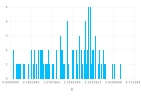

In [13]:
# A histogram of the final cost of each trial shows that most random
# configurations eventually converged to the correct answer (a final
# cost near 0.0), but that some got stuck in local minima

Gadfly.plot(x=[trial[:err][end] for trial in trials], Geom.histogram, Guide.xticks(ticks=collect(0:pi/4:3*pi/2)))

In [63]:
# Now let's repeat the trial, but starting within + or - 0.5 rad of the true
# joint angles (to simulate running online with a good initial guess).

function test_gradient_descent_close(model, sensed_points, true_state, loops)
    x_true = copy(Flash.flatten(true_state))
    trials = Vector{DataFrame}()
    
    for i = 1:loops
        errors = Float64[]
        xs = Vector{Float64}[]
        costs = Float64[]
        
        function callback{T}(x::AbstractVector{T}, c)
            # When computing errors, we'll just ignore the last three joints, since
            # they are almost impossible to track at this scale
            x_value = Flash.value.(x)
            push!(errors, norm(angle_diff.(x_value, x_true)))
            push!(xs, x_value)
            push!(costs, Flash.value(c))
            state = Flash.ManipulatorState(model)
            Flash.GradientDescent.unflatten!(state, x_value)
            settransform!(vis[:robot], state)
        end
        
        x_estimated = copy(x_true)
        x_estimated += (rand(length(x_estimated)) - 0.5)
        Flash.Tracking.estimate_state(model, sensed_points, x_estimated; callback=callback)
        push!(trials, DataFrame(x=xs, err=errors, cost=costs))
    end
    
    trials
end

trials_close = test_gradient_descent_close(arm, sensed_points, true_state, 100);

In [67]:
plt = plot(legend=nothing)
for trial in trials_close
    plot!(plt, trial, :err)
end
plt

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10 
 
 
 20 
 
 
 30 
 
 
 0.2 
 
 
 0.4 
 
 
 0.6 
 
 
 err 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 30.6037,209.187 50.1023,218.751 69.6009,227.228 89.0995,234.779 108.598,241.541 128.097,247.627 147.595,253.129 167.094,258.126 186.592,262.683 206.091,266.856 
 225.59,270.69 245.088,274.224 264.587,277.494 284.085,280.528 303.584,283.35 323.083,285.984 342.581,288.446 362.08,290.755 381.578,292.924 401.077,294.966 
 420.576,296.893 440.074,298.712 459.573,300.435 479.071,302.068 498.57,303.618 518.069,305.091 537.567,306.493 557.066,307.83 576.564,309.104 596.063,310.322 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 30.6037,103.461 50.1023,105.736 69.6009,107.715 89.0995,109.45 108.598,110.983 128.097,112.348 147.595,113.573 167.094,114.68 186.592,115.689 206.091,116.613 
 225.59,117.465 245.088,118.257 264.587,118.997 284.085,119.692 303.584,120.348 323.083,120.971 342.581,121.565 362.08,122.134 381.578,122.681 401.077,123.209 
 420.576,123.721 440.074,124.218 459.573,124.701 479.071,125.174 498.57,125.636 518.069,126.09 537.567,126.535 557.066,126.974 576.564,127.407 596.063,127.833 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#3cb370; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 30.6037,60.5629 50.1023,62.4946 69.6009,64.3082 89.0995,66.0145 108.598,67.623 128.097,69.1421 147.595,70.5794 167.094,71.9416 186.592,73.2348 206.091,74.4643 
 225.59,75.6351 245.088,76.7517 264.587,77.8181 284.085,78.8381 303.584,79.815 323.083,80.7519 342.581,81.6517 362.08,82.517 381.578,83.3503 401.077,84.1539 
 420.576,84.9298 440.074,85.6801 459.573,86.4064 479.071,87.1105 498.57,87.7939 518.069,88.4582 537.567,89.1047 557.066,89.7347 576.564,90.3493 596.063,90.9497 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#d96fd5; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 30.6037,336.059 50.1023,336.934 69.6009,337.791 89.0995,338.631 108.598,339.453 128.097,340.259 147.595,341.049 167.094,341.824 186.592,342.583 206.091,343.327 
 225.59,344.056 245.088,344.771 264.587,345.473 284.085,346.16 303.584,346.835 323.083,347.496 342.581,348.145 362.08,348.782 381.578,349.406 401.077,350.018 
 420.576,350.619 440.074,351.208 459.573,351.787 479.071,352.354 498.57,352.91 518.069,353.457 537.567,353.992 557.066,354.518 576.564,355.034 596.063,355.54 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#b28c19; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 30.6037,189.794 50.1023,195.841 69.6009,201.592 89.0995,207.068 108.598,212.285 128.097,217.26 147.595,222.007 167.094,226.539 186.592,230.869 206.091,235.008 
 225.59,238.967 245.088,242.755 264.587,246.383 284.085,249.858 303.584,253.189 323.083,256.384 342.581,259.45 362.08,262.394 381.578,265.223 401.077,267.942 
 420.576,270.558 440.074,273.075 459.573,275.5 479.071,277.836 498.57,280.089 518.069,282.263 537.567,284.362 557.066,286.389 576.564,288.349 596.063,290.243 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#00abab; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 30.6037,206.986 50.1023,212.744 69.6009,217.894 89.0995,222.521 108.598,226.698 128.097,230.485 147.595,233.932 167.094,237.082 186.592,239.969 206.091,242.626 
 225.59,245.077 245.088,247.347 264.587,249.453 284.085,251.414 303.584,253.244 323.083,254.957 342.581,256.562 362.08,258.071 381.578,259.491 401.077,260.832 
 420.576,262.099 440.074,263.3 459.573,264.438 479.071,265.521 498.57,266.551 518.069,267.532 537.567,268.469 557.066,269.365 576.564,270.222 596.063,271.043 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#ff5d5d; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 30.6037,248.474 50.1023,248.759 69.6009,249.043 89.0995,249.326 108.598,249.609 128.097,249.891 147.595,250.1

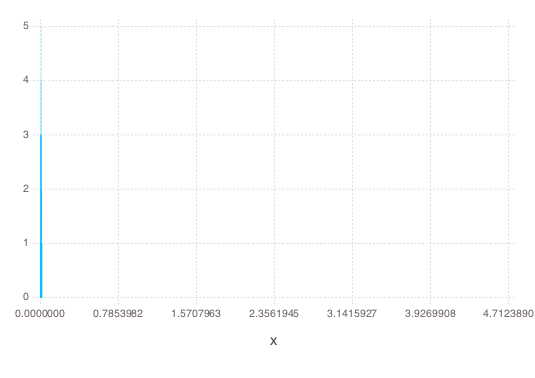

In [109]:
# When starting out reasonably close to the correct configuration, every
# single sample converged to the true joint angles. The histogram confirms:

Gadfly.plot(x=[trial[:err][end] for trial in trials_close], Geom.histogram, Guide.xticks(ticks=collect(0:pi/4:3*pi/2)))

In [110]:
@manipulate for j = 1:length(trials_close), i = 1:size(trials_close[1], 1)
    trial = trials_close[j]
    set_configuration!(state, trial[:x][i])
    Flash.draw(state)
    trial[:x][i], trial[:cost][i]
end

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"j",50,1:100,"d",true)

Interact.Slider{Int64}(Signal{Int64}(15, nactions=0),"i",15,1:30,"d",true)

([3.14754,1.28436],0.00013643120087735436)